## Import Dataset

In [59]:
# Standard libraries
import time
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif
from sklearn.model_selection import (
    GridSearchCV, PredefinedSplit, KFold, StratifiedKFold, train_test_split, cross_val_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, precision_score, recall_score
)
from sklearn.tree import  DecisionTreeClassifier
import pickle


import warnings
warnings.filterwarnings('ignore')

from Preprocessing_functions import *

import importlib
imported_module = importlib.import_module("Preprocessing_functions")
importlib.reload(imported_module)

# pandas max columns display
pd.set_option('display.max_columns', None)

In [60]:
train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')
test_data = pd.read_csv('test_data.csv', index_col='Claim Identifier')

In [61]:
train_data = train_data[~(train_data.drop(columns=['Assembly Date']).isna().all(axis=1) & train_data['Assembly Date'].notna())]

In [62]:
X = train_data.drop(columns=['Claim Injury Type', 'WCB Decision', 'Agreement Reached','OIICS Nature of Injury Description'])
y = train_data['Claim Injury Type']

test_data = test_data.drop(columns=['OIICS Nature of Injury Description'])

In [63]:
y.value_counts(normalize=True) * 100

Claim Injury Type
2. NON-COMP        50.708156
4. TEMPORARY       25.871128
3. MED ONLY        12.003986
5. PPD SCH LOSS     8.410769
1. CANCELLED        2.173595
6. PPD NSL          0.733590
8. DEATH            0.081878
7. PTD              0.016898
Name: proportion, dtype: float64

____

# Pre-processing

## Auxiliary Functions


In [64]:
def create_predifined_split_with_features(X, y, preprocess_steps,selected_features, n_splits = 5):
    """
    Creates a PredefinedSplit object to be used in cross-validation, more specifically in GridSearchCV.

    Steps:
    - Defines the number of splits
    - Splits the data into training and validation sets
    - Applies the preprocessing steps to the training and validation sets
    - Returns the PredefinedSplit object and the preprocessed data
    """

    X_combined_list = []
    y_combined_list = []

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    test_data = np.zeros(len(X), dtype=int) - 1

    for fold_idx, (_, test_idx) in enumerate(kf.split(X, y)):
        test_data[test_idx] = fold_idx

    ps = PredefinedSplit(test_fold=test_data)

    for train_index, test_index in ps.split():

        # Get fold
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        # Preprocess and encode data    
        X_train, X_val = preprocess_steps(X_train, X_val)
        y_train, y_val, le = encoding_label(y_train, y_val)

        X_combined_list.append(X_train[selected_features])
        y_combined_list.append(y_train)

    X_combined = pd.concat(X_combined_list, axis=0)
    y_combined = np.concatenate(y_combined_list, axis=0)

    return ps, X_combined, y_combined

In [65]:
def create_predifined_split(X, y, preprocess_steps, n_splits = 5):
    """
    Creates a PredefinedSplit object to be used in cross-validation, more specifically in GridSearchCV.

    Steps:
    - Defines the number of splits
    - Splits the data into training and validation sets
    - Applies the preprocessing steps to the training and validation sets
    - Returns the PredefinedSplit object and the preprocessed data
    """

    X_combined_list = []
    y_combined_list = []

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    test_data = np.zeros(len(X), dtype=int) - 1

    for fold_idx, (_, test_idx) in enumerate(kf.split(X, y)):
        test_data[test_idx] = fold_idx

    ps = PredefinedSplit(test_fold=test_data)

    for train_index, test_index in ps.split():

        # Get fold
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        # Preprocess and encode data    
        X_train, X_val = preprocess_steps(X_train, X_val)
        y_train, y_val, le = encoding_label(y_train, y_val)

        X_combined_list.append(X_train)
        y_combined_list.append(y_train)

    X_combined = pd.concat(X_combined_list, axis=0)
    y_combined = np.concatenate(y_combined_list, axis=0)

    return ps, X_combined, y_combined

In [66]:
def average_chi2_across_folds_with_predefined_split(X, y, ps):
    """
    Computes the average Chi-Squared score and p-value across folds using a PredefinedSplit.
    """
    feature_scores = []

    for train_idx, test_idx in ps.split():

        X_train, y_train = X.iloc[train_idx], y[train_idx]
        
        chi2_scores, p_values = chi2(X_train, y_train)
        
        feature_scores.append((chi2_scores, p_values))

    chi2_scores_all = np.array([scores[0] for scores in feature_scores])
    p_values_all = np.array([scores[1] for scores in feature_scores])
    
    avg_chi2_scores = np.mean(chi2_scores_all, axis=0)
    avg_p_values = np.mean(p_values_all, axis=0)
    
    results = pd.DataFrame({
        'Feature': X.columns,
        'Average_Chi2_Score': avg_chi2_scores,
        'Average_P_Value': avg_p_values
    }).sort_values(by='Average_Chi2_Score', ascending=False)
    
    return results


In [67]:
def average_anova_across_folds_with_predefined_split(X, y, ps):
    """
    Computes the average ANOVA F-test score and p-value across folds using a PredefinedSplit.
    """
    feature_scores = []
    
    for train_idx, test_idx in ps.split():
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        
        f_scores, p_values = f_classif(X_train, y_train)
        
        feature_scores.append((f_scores, p_values))

    f_scores_all = np.array([scores[0] for scores in feature_scores])
    p_values_all = np.array([scores[1] for scores in feature_scores])
    
    avg_f_scores = np.mean(f_scores_all, axis=0)
    avg_p_values = np.mean(p_values_all, axis=0)
    
    results = pd.DataFrame({
        'Feature': X.columns,
        'Average_F_Score': avg_f_scores,
        'Average_P_Value': avg_p_values
    }).sort_values(by='Average_F_Score', ascending=False)
    
    return results


## List creation for Pre-Processing

In [68]:
CODE_COLUMNS = ['Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

DESCRIPTION_COLUMNS = ['WCIO Cause of Injury Description','WCIO Nature of Injury Description','WCIO Part Of Body Description','Industry Code Description']

BOOLEAN_COLUMNS = ['Alternative Dispute Resolution', 'Attorney/Representative','COVID-19 Indicator']

date_order = ['Accident Date', 'C-2 Date','C-3 Date','Assembly Date', 'First Hearing Date']

numerical_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year', 
    'C-2 Date', 
    'C-3 Date', 
    'First Hearing Date', 
    'IME-4 Count', 
]

outliers_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year',
    'IME-4 Count', 
]

categorical_features = ['Alternative Dispute Resolution',
 'Attorney/Representative',
 'Carrier Name',
 'Carrier Type',
 'County of Injury',
 'COVID-19 Indicator',
 'District Name',
 'Gender',
 'Industry Code',
 'Medical Fee Region',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']


columns_to_scale = ['Accident Date',
                'Assembly Date',
                'Average Weekly Wage',
                'Age at Injury',
                'Birth Year', 
                'Number of Dependents',
                'IME-4 Count']

date_columns = ['Accident Date', 'Assembly Date']

outliers_iqr_specific = ['Age at Injury', 'Birth Year']

columns_to_drop = ['C-2 Date', 'C-3 Date', 'First Hearing Date']

scaling_columns = ['Average Weekly Wage', 'Age at Injury', 'Birth Year', 'Number of Dependents', 'IME-4 Count', 'Days Between Accident Date and Assembly Date']

new_date_features = ['Accident Date_Year', 'Accident Date_Month', 'Accident Date_Day', 'Accident Date_DayOfWeek',
                'Assembly Date_Year', 'Assembly Date_Month', 'Assembly Date_Day', 'Assembly Date_DayOfWeek',
                'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day', 'C-2 Date_DayOfWeek',
                'C-3 Date_Year', 'C-3 Date_Month', 'C-3 Date_Day', 'C-3 Date_DayOfWeek',
                'First Hearing Date_Year', 'First Hearing Date_Month', 'First Hearing Date_Day', 'First Hearing Date_DayOfWeek']

binning_columns = ['Age at Injury', 'Age at Injury', 'Birth Year', 'Average Weekly Wage', 'IME-4 Count']
date_columns = ['Accident Date', 'Assembly Date']

# Create feature lists
date_features = ['Accident Date_Year', 'Accident Date_Month', 'Accident Date_Day', 'Accident Date_DayOfWeek',
                'Assembly Date_Year', 'Assembly Date_Month', 'Assembly Date_Day', 'Assembly Date_DayOfWeek',
                'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day', 'C-2 Date_DayOfWeek']

numeric_features = ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents']

dates_lowMissing = ['Accident Date', 'Assembly Date', 'C-2 Date']
dates_highMissing = ['C-3 Date', 'First Hearing Date']
newBinary = ['Has C-3 Date', 'Has First Hearing Date']

frequency = ['Carrier Name', 'Zip Code']

# Drop unnecessary columns and get features
drop_cols = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date',
            ]

date_features = ['Accident Date_Year', 'Accident Date_Month', 'Accident Date_Day', 'Accident Date_DayOfWeek',
                'Assembly Date_Year', 'Assembly Date_Month', 'Assembly Date_Day', 'Assembly Date_DayOfWeek',
                'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day', 'C-2 Date_DayOfWeek']



low_cardinality_cols = [col for col in categorical_features if X[col].nunique() < 10]
high_cardinality_cols = [col for col in categorical_features if X[col].nunique() > 10]

## Pre-Processing functions

In [69]:
def create_groupingFeatures(X_train, X_val):

    X_train, X_val= newFeature_binnedGroups(X_train, X_val, binning_columns, 6)

    X_train, X_val = newFeature_month(X_train, X_val, date_columns)



    X_train, X_val = newFeature_daysBetween(X_train, X_val, firstDate='Accident Date', secondDate='Assembly Date')
    
    return X_train, X_val

In [70]:


def preprocessing_scaling_encoding_dum(X_train, X_val):
    X_train, X_val = type_conversion_categorical(X_train, X_val,categorical_features)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = log_transform(X_train, X_val)
    X_train, X_val = outliers_specific2(X_train, X_val, outliers_iqr_specific[0], 14)
    X_train, X_val = outliers_specific2(X_train, X_val, outliers_iqr_specific[1], 1934)
    X_train, X_val = scaling_robust(X_train, X_val, columns_to_scale)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)

    return X_train, X_val

In [71]:
def preprocessing_newDate_dum(X_train, X_val):

    X_train, X_val = type_conversion_categorical(X_train, X_val, categorical_features)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numeric_features)
    X_train, X_val = impute_mode_categorical(X_train, X_val, categorical_features)

    X_train, X_val = newFeature_hasIME4(X_train, X_val)
    X_train, X_val= feature_creation_has_Date(X_train, X_val, dates_highMissing)
    X_train, X_val = newFeatures_categoricalDates(X_train, X_val, dates_lowMissing)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, drop_cols)

    X_train, X_val = scaling_standard(X_train, X_val, numeric_features)

    for key in newBinary:
        categorical_features.append(key)

    X_train, X_val = encoding_onehot(X_train, X_val, categorical_features)
    X_train, X_val = encoding_frequency2(X_train, X_val, frequency)

    return X_train, X_val

## Additional Pre-Processing Functions

In [72]:
def preprocessing_newFeatures_dum(X_train, X_val):
    X_train, X_val = type_conversion_categorical(X_train, X_val,categorical_features)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = convert_to_datetime(X_train, X_val, date_columns)
    X_train, X_val= create_groupingFeatures(X_train, X_val)
    X_train, X_val = log_transform(X_train, X_val)
    X_train, X_val = outliers_specific2(X_train, X_val, outliers_iqr_specific[0], 14)
    X_train, X_val = outliers_specific2(X_train, X_val, outliers_iqr_specific[1], 1934)
    X_train, X_val = scaling_robust(X_train, X_val, scaling_columns)
    X_train, X_val = scaling_robust(X_train, X_val, date_columns)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)

    return X_train, X_val

In [73]:
def preprocessing_scaling_encoding_advanced(X_train, X_val):
    X_train, X_val = type_conversion_categorical(X_train, X_val,categorical_features)
    
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    # Knowledge-based imputation of features
    X_train, X_val = fill_missing_codes_description_based(X_train, X_val)
    X_train, X_val = fillna_zip_code(X_train, X_val)
    X_train, X_val = fillnan_accident_date(X_train, X_val)
    X_train, X_val = fillnan_birth_year(X_train, X_val)
    X_train, X_val = impute_weekly_wage_with_zipIndustryCode(X_train, X_val)
    X_train, X_val = fillnan_IME4_count(X_train, X_val)
    X_train, X_val = drop_description_columns(X_train, X_val)

    # Impute still missing values
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = log_transform(X_train, X_val)
    X_train, X_val = outliers_specific2(X_train, X_val, outliers_iqr_specific[0], 14)
    X_train, X_val = outliers_specific2(X_train, X_val, outliers_iqr_specific[1], 1934)
    X_train, X_val = scaling_robust(X_train, X_val, columns_to_scale)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)

    return X_train, X_val

In [74]:
def preprocessing_newFeatures_advanced(X_train, X_val):

    # Type conversion
    X_train, X_val = type_conversion_categorical(X_train, X_val, categorical_features)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)

    

    # Knowledge-based imputation of features
    X_train, X_val = fill_missing_codes_description_based(X_train, X_val)
    X_train, X_val = fillna_zip_code(X_train, X_val)
    X_train, X_val = fillnan_accident_date(X_train, X_val)
    X_train, X_val = fillnan_birth_year(X_train, X_val)
    X_train, X_val = impute_weekly_wage_with_zipIndustryCode(X_train, X_val)
    X_train, X_val = fillnan_IME4_count(X_train, X_val)

    # Impute still missing values
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)

    

    # Feature creation
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = newFeature_hasIME4(X_train, X_val)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_datetime(X_train, X_val, date_columns)

    # Grouping features
    X_train, X_val= create_groupingFeatures(X_train, X_val)

    # Treating outliers
    X_train, X_val = log_transform(X_train, X_val)
    X_train, X_val = outliers_specific2(X_train, X_val, outliers_iqr_specific[0], 14)
    X_train, X_val = outliers_specific2(X_train, X_val, outliers_iqr_specific[1], 1934)

    # Scaling
    X_train, X_val = scaling_robust(X_train, X_val, scaling_columns)
    X_train, X_val = scaling_robust(X_train, X_val, date_columns)

    low_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() < 10]
    high_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() > 10]

    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)

    return X_train, X_val

## Pre-processing for optimized model

In [27]:
def preprocessing_optimized(X_train, X_val):
    categorical_features_optimize = ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Type',
                       'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender',
                       'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code','WCIO Nature of Injury Code', 
                       'WCIO Part Of Body Code']
    
    X_train, X_val = type_conversion_categorical(X_train, X_val, categorical_features_optimize)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = impute_mode_categorical(X_train, X_val, categorical_features_optimize)

    X_train, X_val = newFeature_hasIME4(X_train, X_val)
    X_train, X_val=  feature_creation_has_Date(X_train, X_val, dates_highMissing)
    X_train, X_val = newFeatures_categoricalDates(X_train, X_val, dates_lowMissing)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, drop_cols)

    X_train, X_val = scaling_standard(X_train, X_val, numeric_features)

    for key in newBinary:
        categorical_features_optimize.append(key)

    X_train, X_val = encoding_onehot(X_train, X_val, categorical_features_optimize)
    X_train, X_val = encoding_frequency2(X_train, X_val, frequency)

    return X_train, X_val

# Feature Selection


## Predefined Split

In [82]:
ps, X_combined, y_combined = create_predifined_split(X, y, preprocessing_scaling_encoding_dum, n_splits=5) 

## Chi square and Anova

We decided to take out the colmns that were frequency encoded for this part of the analysis and really on other type of feature selection for those colmns

### Chi square 

In [80]:
#for categorigal features
chi_features = [
    'Has C-3 Date',
    'Has C-2 Date',
    'Has First Hearing Date',
    'Alternative Dispute Resolution_N',
    'Alternative Dispute Resolution_Y',
    'Alternative Dispute Resolution_U',
    'Attorney/Representative_N',
    'Attorney/Representative_Y',
    'Carrier Type_1A. PRIVATE',
    'Carrier Type_2A. SIF',
    'Carrier Type_3A. SELF PUBLIC',
    'Carrier Type_4A. SELF PRIVATE',
    'Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)',
    'Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS',
    'Carrier Type_5D. SPECIAL FUND - UNKNOWN',
    'Carrier Type_UNKNOWN',
    'COVID-19 Indicator_N',
    'COVID-19 Indicator_Y',
    'District Name_NYC',
    'District Name_BUFFALO',
    'District Name_ALBANY',
    'District Name_HAUPPAUGE',
    'District Name_STATEWIDE',
    'District Name_SYRACUSE',
    'District Name_BINGHAMTON',
    'District Name_ROCHESTER',
    'Gender_F',
    'Gender_M',
    'Gender_U',
    'Gender_X',
    'Medical Fee Region_I',
    'Medical Fee Region_II',
    'Medical Fee Region_III',
    'Medical Fee Region_IV',
    'Medical Fee Region_UK'
]
chi2_results = average_chi2_across_folds_with_predefined_split(X_combined[chi_features], y_combined, ps)
chi2_results

,Feature,Average_Chi2_Score,Average_P_Value
7,Attorney/Representative_Y,1.184465e+05,0.000000e+00
6,Attorney/Representative_N,5.595382e+04,0.000000e+00
10,Carrier Type_3A. SELF PUBLIC,7.177575e+03,0.000000e+00
9,Carrier Type_2A. SIF,5.212932e+03,0.000000e+00
17,COVID-19 Indicator_Y,4.274148e+03,0.000000e+00
8,Carrier Type_1A. PRIVATE,2.726281e+03,0.000000e+00
26,Gender_F,2.374563e+03,0.000000e+00
4,Alternative Dispute Resolution_Y,2.003355e+03,0.000000e+00
27,Gender_M,1.813223e+03,0.000000e+00
15,Carrier Type_UNKNOWN,1.451044e+03,3.452917e-297


Only Has C-3 Date, Has C-2 Date, Has First Hearing Date, Alternative Dispute Resolution_nan and Alternative Dispute Resolution_False

### Anova

In [41]:
anova_features =[
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year', 
    'IME-4 Count', 
]
anova_result = average_anova_across_folds_with_predefined_split(X_combined[anova_features], y_combined, ps)
anova_result

,Feature,Average_F_Score,Average_P_Value
3,Average Weekly Wage,174843.294364,0.0
5,IME-4 Count,2955.534057,0.0
1,Age at Injury,1041.869837,0.0
2,Assembly Date,639.697662,0.0
0,Accident Date,541.534905,0.0
4,Birth Year,527.851524,0.0


## Lasso Regression

In [13]:
X_combined.isna().sum()

Accident Date                                               0
Age at Injury                                               0
Assembly Date                                               0
Average Weekly Wage                                         0
Birth Year                                                  0
IME-4 Count                                                 0
Number of Dependents                                        0
Has C-3 Date                                                0
Has C-2 Date                                                0
Has First Hearing Date                                      0
Alternative Dispute Resolution_N                            0
Alternative Dispute Resolution_U                            0
Alternative Dispute Resolution_Y                            0
Attorney/Representative_N                                   0
Attorney/Representative_Y                                   0
Carrier Type_1A. PRIVATE                                    0
Carrier 

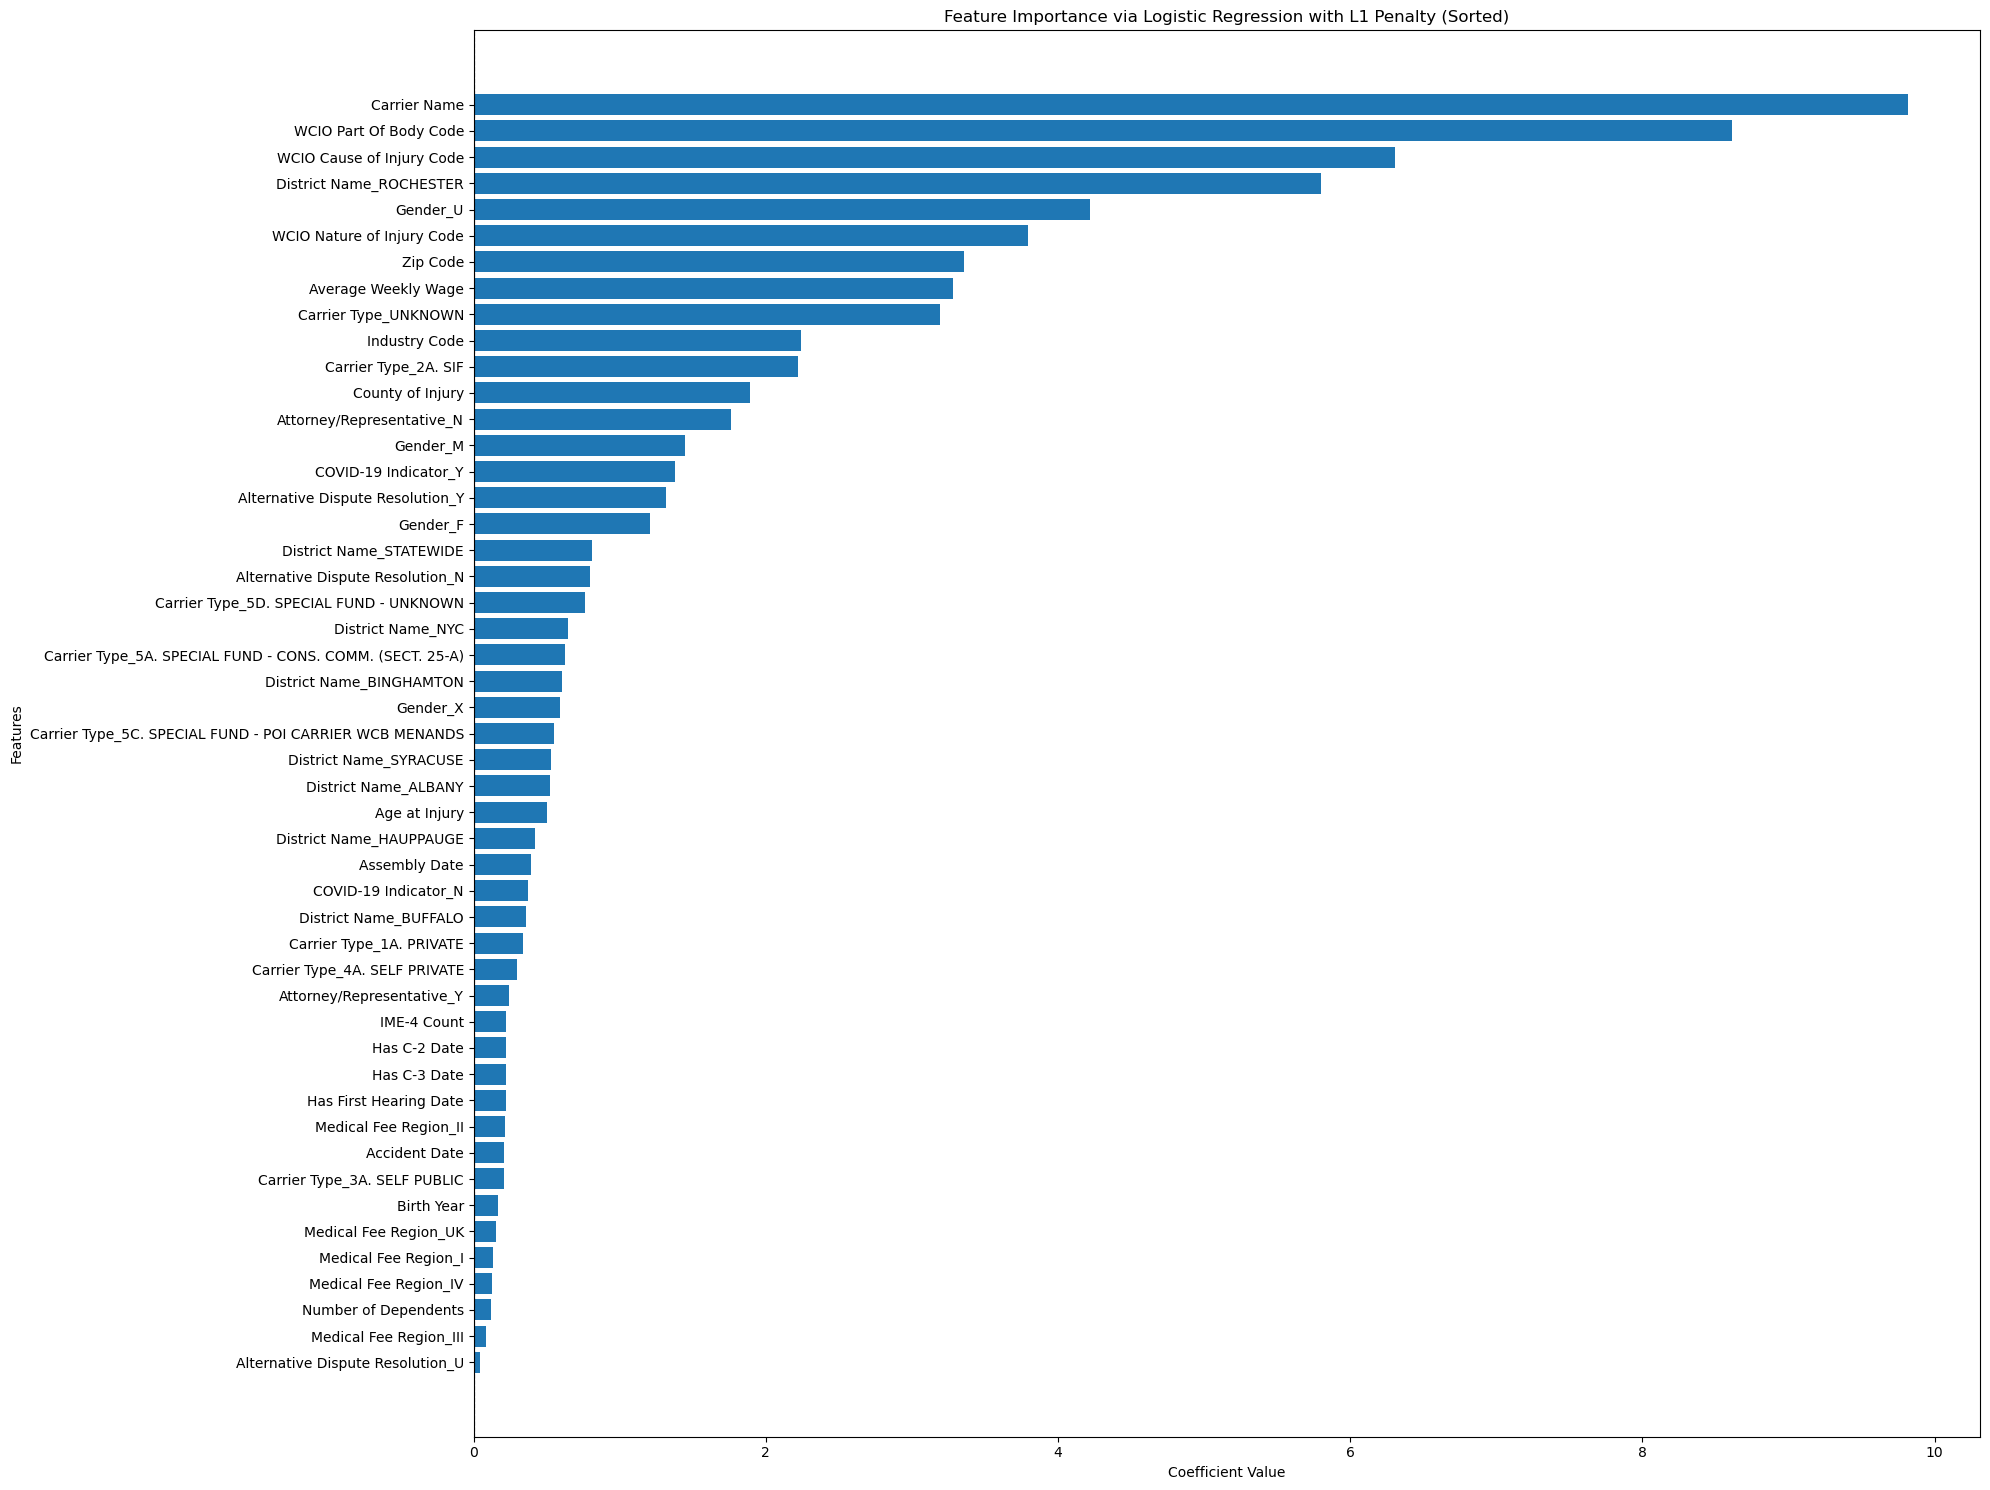

Selected Features: ['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Has C-3 Date', 'Has C-2 Date', 'Has First Hearing Date', 'Alternative Dispute Resolution_N', 'Alternative Dispute Resolution_U', 'Alternative Dispute Resolution_Y', 'Attorney/Representative_N', 'Attorney/Representative_Y', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)', 'Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS', 'Carrier Type_5D. SPECIAL FUND - UNKNOWN', 'Carrier Type_UNKNOWN', 'COVID-19 Indicator_N', 'COVID-19 Indicator_Y', 'District Name_ALBANY', 'District Name_BINGHAMTON', 'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_ROCHESTER', 'District Name_STATEWIDE', 'District Name_SYRACUSE', 'Gender_F', 'Gender_M', 'Gender_U', 'Gender_X', 'Medical Fee Region_I', '

In [14]:
logreg_cv = LogisticRegressionCV(
    penalty='l1',
    solver='saga', # Use SAGA solver for large datasets 
    Cs=5,
    cv=ps,
    random_state=42,
    class_weight='balanced', # Balance class weights
    n_jobs=-1,
    scoring='f1_macro', # Use macro F1 score as scoring metric
    max_iter=2000
)
logreg_cv.fit(X_combined, y_combined)

# Identify selected and unselected features
if len(logreg_cv.coef_.shape) > 1:
    coefs = np.abs(logreg_cv.coef_).mean(axis=0)
else:
    coefs = logreg_cv.coef_.flatten()

selected_features = X_combined.columns[coefs != 0].tolist()
unselected_features = X_combined.columns[coefs == 0].tolist()

sorted_idx = np.argsort(np.abs(coefs))
sorted_features = X_combined.columns[sorted_idx]
sorted_coefs = coefs[sorted_idx]

plt.figure(figsize=(20, 15))
plt.barh(sorted_features, sorted_coefs)
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Feature Importance via Logistic Regression with L1 Penalty (Sorted)")
plt.axvline(0, color="black", linewidth=0.8, linestyle="--")
plt.tight_layout()
plt.show()

print("Selected Features:", selected_features)
print("Unselected Features:", unselected_features)


In [15]:
# put features together with there coefficients
feature_importance = pd.DataFrame({'Feature': sorted_features, 'Coefficient': sorted_coefs})
feature_importance

,Feature,Coefficient
0,Alternative Dispute Resolution_U,0.043451
1,Medical Fee Region_III,0.087309
2,Number of Dependents,0.116237
3,Medical Fee Region_IV,0.129002
4,Medical Fee Region_I,0.134702
5,Medical Fee Region_UK,0.156111
6,Birth Year,0.167835
7,Carrier Type_3A. SELF PUBLIC,0.210741
8,Accident Date,0.211036
9,Medical Fee Region_II,0.213772


## RFECV with preprocessing_scaling_encoding_dum (All features)

In [ ]:
 # Initialize RandomForest model
rf_model = RandomForestClassifier(
    n_estimators=100,            # Number of trees
    max_depth=15,                # Limit tree depth
    min_samples_split=50,        # Minimum samples for a split
    min_samples_leaf=20,         # Minimum samples per leaf
    max_features='sqrt',         # Features to consider per split
    class_weight='balanced',     # Handle class imbalance
    bootstrap=True,              # Use bootstrapping
    random_state=42,             # Ensure reproducibility
    n_jobs=-1                    # Use all CPU cores
)

# Set up RFECV with RandomForest and cross-validation
rfecv = RFECV(estimator=rf_model, step=1, cv=ps, scoring='f1_macro') 

# Fit RFECV
rfecv.fit(X_combined, y_combined)

#Get the selected features
selected_features_RFE_basic = X_combined.columns[rfecv.support_].tolist()
optimal_num_features = rfecv.n_features_
feature_ranking = rfecv.ranking_

print("Optimal number of features:", optimal_num_features)
print("Selected Features:", selected_features_RFE_basic)

Optimal number of features: 26
Selected Features: ['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Attorney/Representative_N', 'Attorney/Representative_Y', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'COVID-19 Indicator_N', 'COVID-19 Indicator_Y', 'District Name_NYC', 'Gender_F', 'Gender_M', 'Medical Fee Region_I', 'Medical Fee Region_IV', 'Carrier Name', 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code']


In [ ]:
feature_ranking = pd.DataFrame({'Feature': X_combined.columns, 'Ranking': feature_ranking})
Optimal_number_of_features = 26

In [ ]:
feature_ranking

,Feature,Ranking
0,Accident Date,1
1,Age at Injury,1
2,Assembly Date,1
3,Average Weekly Wage,1
4,Birth Year,1
5,IME-4 Count,1
6,Number of Dependents,1
7,Has C-3 Date,19
8,Has C-2 Date,21
9,Has First Hearing Date,24


Optimal number of features: 26<br>

Selected Features: ['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Attorney/Representative_N', 'Attorney/Representative_Y', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'COVID-19 Indicator_N', 'COVID-19 Indicator_Y', 'District Name_NYC', 'Gender_F', 'Gender_M', 'Medical Fee Region_I', 'Medical Fee Region_IV', 'Carrier Name', 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code']


In [32]:
selected_features_RFE_basic = ['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Attorney/Representative_N', 'Attorney/Representative_Y', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'COVID-19 Indicator_N', 'COVID-19 Indicator_Y', 'District Name_NYC', 'Gender_F', 'Gender_M', 'Medical Fee Region_I', 'Medical Fee Region_IV', 'Carrier Name', 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code']

## Feature selection report (simple preprocesing)

| Feature                                      | Lasso       | RFE | Chi-Square AND Anova |
|----------------------------------------------|-------------|-----|----------------------|
| Accident Date                                | 0.211036    | 1   | Yes                  |
| Age at Injury                                | 0.504248    | 1   | Yes                  |
| Assembly Date                                | 0.390846    | 1   | Yes                  |
| Average Weekly Wage                          | 3.280818    | 1   | Yes                  |
| Birth Year                                   | 0.167835    | 1   | Yes                  |
| IME-4 Count                                  | 0.223878    | 1   | Yes                  |
| Number of Dependents                         | 0.116237    | 1   | Yes                  |
| Attorney/Representative_N                   | 1.759923    | 1   | Yes                  |
| Attorney/Representative_Y                   | 0.242048    | 1   | Yes                  |
| Carrier Type_1A. PRIVATE                     | 0.338307    | 1   | Yes                  |
| Carrier Type_2A. SIF                         | 2.216751    | 1   | Yes                  |
| Carrier Type_3A. SELF PUBLIC                 | 0.210741    | 1   | Yes                  |
| COVID-19 Indicator_N                         | 0.370451    | 1   | Yes                  |
| COVID-19 Indicator_Y                         | 1.378582    | 1   | Yes                  |
| District Name_NYC                            | 0.648644    | 1   | Yes                  |
| Gender_F                                     | 1.208189    | 1   | Yes                  |
| Gender_M                                     | 1.446775    | 1   | Yes                  |
| Medical Fee Region_I                         | 0.134702    | 1   | Yes                  |
| Medical Fee Region_IV                        | 0.129002    | 1   | Yes                  |
| Carrier Name                                 | 9.819424    | 1   | NAN                  |
| County of Injury                             | 1.893634    | 1   | NAN                  |
| Industry Code                                | 2.242221    | 1   | NAN                  |
| WCIO Cause of Injury Code                    | 6.305754    | 1   | NAN                  |
| WCIO Nature of Injury Code                   | 3.793246    | 1   | NAN                  |
| WCIO Part Of Body Code                       | 8.615316    | 1   | NAN                  |
| Zip Code                                     | 3.354948    | 1   | NAN                  |
| District Name_STATEWIDE                      | 0.808032    | 2   | Yes                  |
| District Name_ALBANY                         | 0.523575    | 3   | Yes                  |
| District Name_BUFFALO                        | 0.359422    | 4   | Yes                  |
| District Name_HAUPPAUGE                      | 0.416995    | 5   | Yes                  |
| Medical Fee Region_UK                        | 0.156111    | 6   | Yes                  |
| Medical Fee Region_II                        | 0.213772    | 7   | Yes                  |
| District Name_SYRACUSE                       | 0.527618    | 8   | Yes                  |
| Medical Fee Region_III                       | 0.087309    | 9   | Yes                  |
| Carrier Type_4A. SELF PRIVATE                | 0.296296    | 10  | Yes                  |
| District Name_ROCHESTER                      | 5.801763    | 11  | Yes                  |
| Alternative Dispute Resolution_N            | 0.793051    | 12  | No                   |
| Carrier Type_5D. SPECIAL FUND - UNKNOWN      | 0.763613    | 13  | Yes                  |
| District Name_BINGHAMTON                     | 0.601370    | 14  | Yes                  |
| Alternative Dispute Resolution_Y            | 1.317285    | 15  | Yes                  |
| Gender_U                                     | 4.216955    | 16  | Yes                  |
| Carrier Type_UNKNOWN                         | 3.189715    | 17  | Yes                  |
| Gender_X                                     | 0.588001    | 18  | Yes                  |
| Has C-3 Date                                 | 0.222943    | 19  | No                   |
| Carrier Type_5C. SPECIAL FUND - POI CARRIE...| 0.546666    | 20  | Yes                  |
| Has C-2 Date                                 | 0.222943    | 21  | No                   |
| Carrier Type_5A. SPECIAL FUND - CONS. COMM...| 0.627244    | 22  | Yes                  |
| Alternative Dispute Resolution_U            | 0.043451    | 23  | No                   |
| Has First Hearing Date                       | 0.222943    | 24  | No                   |


______

# Model Assessment

In this section we are tuning the hyperparameter for all models using GridSearch
- All models get the same pre-processed data set across the same folds (PredefinedSplit)
- The feature selected are the one selected with the RFECV (preprocessing_scaling_encoding_dum)<br>

Afterwards all tuned models get evaluted based on their performance for predictions on train and val across all folds.

Create PredefinedSplit with selected features

In [50]:
ps_grid, X_combined, y_combined = create_predifined_split_with_features(X, y, preprocessing_scaling_encoding_dum,selected_features_RFE_basic, n_splits=5)

## GridSearchCV

In [34]:
def get_best_parameters(X, y, model, param_grid, ps, n_splits=5):
    """
    Finds the best hyperparameters for a given model using GridSearchCV.

    Steps:
    - Creates a PredefinedSplit object
    - Creates a GridSearchCV object
    - Fits the GridSearchCV object
    - Returns the best hyperparameters and the best score
    """

    scoring = make_scorer(f1_score, average='macro')

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=ps,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_combined, y_combined)

    print("Best Parameters:", grid_search.best_params_)
    print("Best F1-macro Score:", grid_search.best_score_)

    return grid_search.best_params_, grid_search.best_score_

### Logistic Regression

In [35]:
param_grid = {
    'penalty': ['l2', 'elasticnet'],         
    'C': [0.01, 0.1, 1, 10],              
    'solver': ['lbfgs', 'saga'],            
    'class_weight': ['balanced', None],      
    'l1_ratio': [0.5]                   
}

model = LogisticRegression(max_iter=1000)

In [36]:
# logisticregression_best_param, logisticregression_best_score = get_best_parameters(X_combined, y_combined, model, param_grid, ps_grid, n_splits=5)

Best Parameters: 
- 'penalty': l2
- 'C': 10
- 'solver': 'lbfgs'
- 'class_weight': 'balanced' 
- 'l1_ratio': 0.5 <br>

### Decision Trees

In [37]:
param_grid = {
    'max_depth': [None, 6],              
    'min_samples_split': [2, 5],         
    'min_samples_leaf': [1, 2],          
    'max_features': ['sqrt', 'log2']
}

model = DecisionTreeClassifier(random_state=42)

In [38]:
#dt_best_param, dt_best_score = get_best_parameters(X_combined, y_combined, model, param_grid, ps_grid, n_splits=5)

Best Parameters: 
- 'max_depth': None
- 'max_features': 'sqrt'
- 'min_samples_leaf': 1
- 'min_samples_split': 2

### Random Forest

In [39]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
model=RandomForestClassifier()

In [40]:
#RandomForestClassifier_best_param, RandomForestClassifier_best_score = get_best_parameters(X_combined, y_combined, model, param_grid, ps_grid, n_splits=5)

Best Parameters: 
- 'bootstrap': False
- 'max_depth': None
- 'max_features': 'sqrt'
- 'min_samples_leaf': 1
- 'min_samples_split': 2
-  'n_estimators': 200 <br>

### NN

In [42]:
param_grid = {
    'hidden_layer_sizes': [
        (int(0.75 * len(selected_features_RFE_basic)), int(0.5 * len(selected_features_RFE_basic))),  # Original configuration
        (int(0.5 * len(selected_features_RFE_basic)), int(0.25 * len(selected_features_RFE_basic)), int(0.125 * len(selected_features_RFE_basic))),  # Three layers
    ],
    'learning_rate_init': [0.01, 0.1],  # Test lower and higher learning rates
    'activation': ['relu', 'tanh'],  # Compare relu and tanh
    'alpha': [0.001, 0.01],  # Regularization strength
    'batch_size': ['auto', 64, 128],  # Test different batch sizes
}
model = MLPClassifier(solver='adam',max_iter=1000,random_state=42)

In [ ]:
#nnGS_best_params, nnGS_best_score = get_best_parameters(X_combined, y_combined, model, param_grid, ps_grid, n_splits=5)

Best Parameters:
- 'activation': 'tanh'
- 'alpha': 0.001
- 'batch_size': 'auto' 
- 'hidden_layer_sizes': (34, 23)
- 'learning_rate_init': 0.01<br>

### XGBoost

In [ ]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.3],
    'gamma': [0, 2],
    'reg_alpha': [0, 5],
    'reg_lambda': [1, 10],
    'min_child_weight': [1, 5] 
}
model=XGBClassifier(random_state=42, n_jobs=-1)

In [ ]:
#xgb_best_params, xgb_best_score = get_best_parameters(X_combined, y_combined, model, param_grid, ps_grid, n_splits=5)

Best Parameters: 
- 'gamma': 0
- 'learning_rate': 0.3
- 'max_depth': 6
-  'min_child_weight': 1
-  'n_estimators': 100
-  'reg_alpha': 0
-  'reg_lambda': 1<br>

### kNN

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform'], # Weight function
    'metric': ['minkowski'],
    'p': [1, 2], # Power parameter for Minkowski distance
    'algorithm': ['auto', 'ball_tree'],  # Algorithm for nearest neighbor search
    'leaf_size': [20, 30, 40, 50] 
}

model=KNeighborsClassifier()

In [ ]:
#knn_best_param, knn_best_score = get_best_parameters(X_combined, y_combined, model, param_grid, ps_grid, n_splits=5)

Knn_best_parameter:
- 'algorithm': 'auto'
- 'leaf_size': 20
- 'metric': 'minkowski'
- 'n_neighbors': 5
- 'p': 1
- 'weights': 'uniform' <br>

## Performance Evaluation

In [45]:
def evaluate_models_with_overfitting_check(X, y, predefined_split, selected_features, models):
    """
    Evaluates multiple models on a dataset with a predefined split and calculates train-test metric differences.
    
    Parameters:
    - X (pd.DataFrame): Feature dataset.
    - y (pd.Series or np.array): Target variable.
    - predefined_split (PredefinedSplit): Predefined split object for cross-validation.
    - models (dict): Dictionary of models, where keys are model names and values are model instances.
    
    Returns:
    - pd.DataFrame: Summary table with mean, variance, and train-test differences for evaluation metrics.
    """
    results = []

    for model_name, model in models.items():
        fold_metrics = {
            'accuracy_train': [],
            'accuracy_test': [],
            'precision_macro_train': [],
            'precision_macro_test': [],
            'recall_macro_train': [],
            'recall_macro_test': [],
            'f1_macro_train': [],
            'f1_macro_test': []
        }
        
        # Loop through predefined splits
        for train_idx, test_idx in predefined_split.split():
            # Split data
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Train model
            model.fit(X_train[selected_features], y_train)
            
            # Predict on train and test data
            y_train_pred = model.predict(X_train[selected_features])
            y_test_pred = model.predict(X_test[selected_features])
            
            # Calculate metrics for train and test data
            fold_metrics['accuracy_train'].append(accuracy_score(y_train, y_train_pred))
            fold_metrics['accuracy_test'].append(accuracy_score(y_test, y_test_pred))
            fold_metrics['precision_macro_train'].append(precision_score(y_train, y_train_pred, average='macro', zero_division=0))
            fold_metrics['precision_macro_test'].append(precision_score(y_test, y_test_pred, average='macro', zero_division=0))
            fold_metrics['recall_macro_train'].append(recall_score(y_train, y_train_pred, average='macro', zero_division=0))
            fold_metrics['recall_macro_test'].append(recall_score(y_test, y_test_pred, average='macro', zero_division=0))
            fold_metrics['f1_macro_train'].append(f1_score(y_train, y_train_pred, average='macro', zero_division=0))
            fold_metrics['f1_macro_test'].append(f1_score(y_test, y_test_pred, average='macro', zero_division=0))
        
        # Calculate mean, variance, and train-test differences for each metric
        for metric_name in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']:
            train_metric = np.array(fold_metrics[f'{metric_name}_train'])
            test_metric = np.array(fold_metrics[f'{metric_name}_test'])
            
            mean_train = np.mean(train_metric)
            mean_test = np.mean(test_metric)
            variance_train = np.var(train_metric)
            variance_test = np.var(test_metric)
            mean_difference = mean_train - mean_test
            
            results.append({
                'Model': model_name,
                'Metric': metric_name,
                'Mean_Train': mean_train,
                'Mean_Test': mean_test,
                'Variance_Train': variance_train,
                'Variance_Test': variance_test,
                'Train-Test_Difference': mean_difference
            })
        
        print(results)
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


In [46]:
models = {
    'Logistic Regression': LogisticRegression(penalty='l2', C=10, solver='lbfgs', class_weight='balanced', l1_ratio=0.5, max_iter=1000, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_neighbors=3, weights='uniform', metric='minkowski', p=1, algorithm='auto', leaf_size=20, n_jobs=-1),
    'MLP': MLPClassifier( solver='adam', max_iter=1000, random_state=42, activation='tanh', alpha=0.001, batch_size='auto', hidden_layer_sizes=(int(0.75 * len(selected_features_RFE_basic)), int(0.5 * len(selected_features_RFE_basic))), learning_rate_init=0.01),
    'Decision Tree': DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', bootstrap=False, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(gamma = 0, learning_rate = 0.3, max_depth = 6, min_child_weight = 1, n_estimators = 200, reg_alpha = 0, reg_lambda = 1,random_state=42, n_jobs=-1)   
}

In [ ]:
performance_results = evaluate_models_with_overfitting_check(X_combined, y_combined, ps, selected_features_RFE_basic, models)

In [ ]:
performance_results

,Model,Metric,Mean_Train,Mean_Test,Variance_Train,Variance_Test,Train-Test_Difference
0,Logistic Regression,accuracy,0.564886,0.564436,7.678480e-07,2.207548e-06,0.000450
1,Logistic Regression,precision_macro,0.309134,0.308626,8.193642e-08,6.239134e-07,0.000509
2,Logistic Regression,recall_macro,0.521869,0.507157,3.274189e-06,7.775047e-05,0.014713
3,Logistic Regression,f1_macro,0.293681,0.292995,2.041098e-07,1.228930e-06,0.000686
4,KNN,accuracy,0.845277,0.696979,1.107867e-07,1.082934e-06,0.148298
5,KNN,precision_macro,0.775405,0.363293,3.003487e-05,3.064116e-04,0.412112
6,KNN,recall_macro,0.596921,0.325319,7.665585e-05,3.474565e-05,0.271602
7,KNN,f1_macro,0.655521,0.334690,6.426812e-05,7.090789e-05,0.320831
8,MLP,accuracy,0.764883,0.764262,4.956358e-06,2.358998e-06,0.000621
9,MLP,precision_macro,0.400243,0.410917,7.107620e-05,1.093682e-03,-0.010674


In [ ]:
performance_results.to_csv('performance_results.csv', index=False)

### Ensemble Prediction

No further use of this ensemble or the findings Therefore not mentioned on the report.

In [ ]:
def evaluate_stacking_with_predefined_split(X, y, predefined_split, base_model, meta_model):
    """
    Creates and evaluates a stacking ensemble with one base model and a meta model using a predefined split.
    
    Parameters:
    - X (pd.DataFrame): Feature dataset.
    - y (pd.Series or np.array): Target variable.
    - predefined_split (PredefinedSplit): Predefined split object for cross-validation.
    - base_model: Base model instance (e.g., XGBoost, Random Forest).
    - meta_model: Meta-model instance (e.g., Logistic Regression).
    
    Returns:
    - pd.DataFrame: Summary table with mean, variance, and train-test differences for evaluation metrics.
    """
    # Initialize storage for predictions and metrics
    base_predictions = np.zeros((len(y),))  # For storing base model predictions
    fold_metrics = {
        'accuracy_train': [],
        'accuracy_test': [],
        'precision_macro_train': [],
        'precision_macro_test': [],
        'recall_macro_train': [],
        'recall_macro_test': [],
        'f1_macro_train': [],
        'f1_macro_test': []
    }
    
    # Split data based on predefined split
    for train_idx, test_idx in predefined_split.split():
        # Split into train and test
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train the base model on training data
        base_model.fit(X_train, y_train)
        # Make predictions with the base model on training data
        base_train_pred = base_model.predict(X_train)
        base_test_pred = base_model.predict(X_test)
        
        # Store base model predictions as features for the meta model
        base_predictions[train_idx] = base_train_pred  # Predictions on training set only
        
        # Train the meta-model on the stacked features
        meta_model.fit(base_predictions[train_idx].reshape(-1, 1), y_train)
        
        # Meta-model predictions on training and test sets
        meta_train_pred = meta_model.predict(base_predictions[train_idx].reshape(-1, 1))
        meta_test_pred = meta_model.predict(base_test_pred.reshape(-1, 1))
        
        # Evaluate metrics on both training and test sets
        fold_metrics['accuracy_train'].append(accuracy_score(y_train, meta_train_pred))
        fold_metrics['accuracy_test'].append(accuracy_score(y_test, meta_test_pred))
        fold_metrics['precision_macro_train'].append(precision_score(y_train, meta_train_pred, average='macro', zero_division=0))
        fold_metrics['precision_macro_test'].append(precision_score(y_test, meta_test_pred, average='macro', zero_division=0))
        fold_metrics['recall_macro_train'].append(recall_score(y_train, meta_train_pred, average='macro', zero_division=0))
        fold_metrics['recall_macro_test'].append(recall_score(y_test, meta_test_pred, average='macro', zero_division=0))
        fold_metrics['f1_macro_train'].append(f1_score(y_train, meta_train_pred, average='macro', zero_division=0))
        fold_metrics['f1_macro_test'].append(f1_score(y_test, meta_test_pred, average='macro', zero_division=0))
    
    # Compute mean, variance, and train-test differences
    results = []
    for metric_name in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']:
        train_metric = np.array(fold_metrics[f'{metric_name}_train'])
        test_metric = np.array(fold_metrics[f'{metric_name}_test'])
        
        mean_train = np.mean(train_metric)
        mean_test = np.mean(test_metric)
        variance_train = np.var(train_metric)
        variance_test = np.var(test_metric)
        mean_difference = mean_train - mean_test
        
        results.append({
            'Metric': metric_name,
            'Mean_Train': mean_train,
            'Mean_Test': mean_test,
            'Variance_Train': variance_train,
            'Variance_Test': variance_test,
            'Train-Test_Difference': mean_difference
        })
    
    return pd.DataFrame(results)

In [ ]:
base_model = XGBClassifier(gamma = 0, learning_rate = 0.3, max_depth = 6, min_child_weight = 1, n_estimators = 200, reg_alpha = 0, reg_lambda = 1,random_state=42, n_jobs=-1)
meta_model = LogisticRegression(penalty='l2', C=10, solver='lbfgs', class_weight='balanced', l1_ratio=0.5, max_iter=2000, n_jobs=-1),

stacking_results = evaluate_stacking_with_predefined_split(X_combined, y_combined, ps, base_model, meta_model)

In [ ]:
stacking_results

,Metric,Mean_Train,Mean_Test,Variance_Train,Variance_Test,Train-Test_Difference
0,accuracy,0.818854,0.794342,2.091752e-07,5.559157e-07,0.024512
1,precision_macro,0.863878,0.756329,9.650562e-07,1.466552e-04,0.107549
2,recall_macro,0.694795,0.459673,2.481437e-06,1.284234e-04,0.235122
3,f1_macro,0.721205,0.502512,3.229257e-06,2.470566e-04,0.218693


In [ ]:
def fit_and_predict_stacking_multiclass(train_X, train_y, test_X, base_model, meta_model, selected_features):
    """
    Fits a stacking ensemble for multiclass classification using XGBoost as the base model
    and Logistic Regression as the meta-model.

    Parameters:
    - train_X (pd.DataFrame): Training features.
    - train_y (pd.Series or np.array): Training labels (multiclass).
    - test_X (pd.DataFrame): Test features.
    - base_model: Base model instance (XGBoost).
    - meta_model: Meta-model instance (Logistic Regression).
    - selected_features (list): List of feature names to use for training.

    Returns:
    - np.array: Predicted labels for the test data.
    """
    # Step 1: Train the base model on the training data
    base_model.fit(train_X[selected_features], train_y)

    # Step 2: Generate base model predictions for train and test sets (probabilities for all classes)
    base_train_predictions = base_model.predict_proba(train_X[selected_features])  # Probabilities for all classes
    base_test_predictions = base_model.predict_proba(test_X[selected_features])

    # Step 3: Train the meta-model on the base model's train predictions
    meta_model.fit(base_train_predictions, train_y)

    # Step 4: Use the meta-model to predict test labels based on base model's test predictions
    meta_test_predictions = meta_model.predict(base_test_predictions)

    return meta_test_predictions


# Model Optimization

### RFECV with preprocessing_newFeatures_advanced (All features)

In [53]:
ps_adv, X_combined, y_combined = create_predifined_split(X, y, preprocessing_newFeatures_advanced, n_splits=5) 

In [ ]:
 # Initialize RandomForest model
rf_model = RandomForestClassifier(
    n_estimators=100,            # Number of trees
    max_depth=15,                # Limit tree depth
    min_samples_split=50,        # Minimum samples for a split
    min_samples_leaf=20,         # Minimum samples per leaf
    max_features='sqrt',         # Features to consider per split
    class_weight='balanced',     # Handle class imbalance
    bootstrap=True,              # Use bootstrapping
    random_state=42,             # Ensure reproducibility
    n_jobs=-1                    # Use all CPU cores
)

# Set up RFECV with RandomForest and cross-validation
rfecv = RFECV(estimator=rf_model, step=1, cv=ps_adv, scoring='f1_macro', n_jobs=-1) 

# Fit RFECV
rfecv.fit(X_combined, y_combined)

#Get the selected features
selected_features_RFE_advanced = X_combined.columns[rfecv.support_].tolist()
feature_ranking = rfecv.ranking_
optimal_num_features = rfecv.n_features_

print("Optimal number of features:", optimal_num_features)
print("Feature Ranking:", feature_ranking)
print("Selected Features:", selected_features_RFE_advanced)

Optimal number of features: 49
Feature Ranking: [ 1  1  1  1  1  1  1 13 18 17 20  4  1  1  1  1  1  1  1  1  1  3  5  1
  1  1  1  1 24 26 28 31 30 29 27 14 21 23 22 32 34 36 38 40 42 44 43 41
 39 37 35 33 12  6  8 25  1  1  1  1  1  1 19 15  9 11  1  1  1  7  1  1
  1  2  1  1  1  1 10 16  1  1  1  1  1  1  1  1  1  1  1  1]
Selected Features: ['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Age at Injury 1', 'Age at Injury 2', 'Age at Injury 3', 'Age at Injury 4', 'Age at Injury 5', 'Birth Year 0', 'Birth Year 1', 'Birth Year 2', 'Birth Year 3', 'Average Weekly Wage 0', 'Average Weekly Wage 1', 'Average Weekly Wage 2', 'IME-4 Count 0', 'IME-4 Count 1', 'Attorney/Representative_False', 'Attorney/Representative_True', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'COVID-19 Indicator_False', 'COVID-19 Indicator_True', 'District Name_ALBA

Optimal number of features: 49 <br>
Selected Features: <br>['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Age at Injury 1', 'Age at Injury 2', 'Age at Injury 3', 'Age at Injury 4', 'Age at Injury 5', 'Birth Year 0', 'Birth Year 1', 'Birth Year 2', 'Birth Year 3', 'Average Weekly Wage 0', 'Average Weekly Wage 1', 'Average Weekly Wage 2', 'IME-4 Count 0', 'IME-4 Count 1', 'Attorney/Representative_False', 'Attorney/Representative_True', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'COVID-19 Indicator_False', 'COVID-19 Indicator_True', 'District Name_ALBANY', 'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_STATEWIDE', 'District Name_SYRACUSE', 'Gender_F', 'Gender_M', 'Medical Fee Region_I', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_IV', 'Medical Fee Region_UK', 'Carrier Name', 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code']

In [77]:
selected_features_RFE_advanced = ['Accident Date', 'Age at Injury', 'Assembly Date', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'IME-4 Count 1', 'Attorney/Representative_N', 'Attorney/Representative_Y', 'COVID-19 Indicator_Y', 'Carrier Name', 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code']

## Performance Evaluation XGBoost Classifier

In this section we try to optimise the performance of our chosen model

1. Evaluation of perfromance on different pre-processings pipelines

In [79]:
ps_newF_dum, X_combined2, y_combined2 = create_predifined_split_with_features(X, y, preprocessing_newFeatures_dum, selected_features_RFE_advanced, n_splits=5)
ps_adv, X_combined3, y_combined3 = create_predifined_split_with_features(X, y, preprocessing_scaling_encoding_advanced, selected_features_RFE_basic, n_splits=5)
ps_newF_adv, X_combined4, y_combined4 = create_predifined_split_with_features(X, y, preprocessing_newFeatures_advanced, selected_features_RFE_advanced, n_splits=5)
ps_dum, X_combined1, y_combined1 = create_predifined_split_with_features(X, y, preprocessing_scaling_encoding_dum, selected_features_RFE_basic, n_splits=5)

In [53]:
def evaluate_model_with_multiple_splits(splits_data, selected_features, model):
    """
    Evaluates a model on multiple predefined splits and stores performance metrics, 
    predictions on train/validation, and train-validation differences.

    Parameters:
    - splits_data (dict): Dictionary where each key is the split name, and the value is a dictionary with:
                          'predefined_split': PredefinedSplit object,
                          'X': Feature dataset (pd.DataFrame),
                          'y': Target variable (pd.Series or np.array).
    - model: Machine learning model instance (e.g., XGBClassifier, RandomForestClassifier).

    Returns:
    - pd.DataFrame: A DataFrame with mean accuracy, F1 scores, and train-validation differences for each split.
    """
    results = []

    for split_name, split_info in splits_data.items():
        print(f"Evaluating model on split: {split_name}")

        predefined_split = split_info['predefined_split']
        X = split_info['X']
        y = split_info['y']

        train_accuracies = []
        val_accuracies = []
        train_f1_scores = []
        val_f1_scores = []

        # Iterate through each fold in the predefined split
        for train_idx, test_idx in predefined_split.split():
            # Split data into train and validation sets
            X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y[train_idx], y[test_idx]

            # Train the model
            model.fit(X_train[selected_features], y_train)

            # Predictions and evaluation
            y_train_pred = model.predict(X_train[selected_features])
            y_val_pred = model.predict(X_val[selected_features])

            # Calculate performance metrics
            train_accuracies.append(accuracy_score(y_train, y_train_pred))
            val_accuracies.append(accuracy_score(y_val, y_val_pred))
            train_f1_scores.append(f1_score(y_train, y_train_pred, average='macro'))
            val_f1_scores.append(f1_score(y_val, y_val_pred, average='macro'))

        # Compute mean accuracy and F1 score for training and validation
        mean_train_accuracy = np.mean(train_accuracies)
        mean_val_accuracy = np.mean(val_accuracies)
        mean_train_f1 = np.mean(train_f1_scores)
        mean_val_f1 = np.mean(val_f1_scores)

        # Calculate train-validation differences
        accuracy_difference = mean_train_accuracy - mean_val_accuracy
        f1_difference = mean_train_f1 - mean_val_f1

        # Store results
        results.append({
            'Split': split_name,
            'Mean_Train_Accuracy': mean_train_accuracy,
            'Mean_Val_Accuracy': mean_val_accuracy,
            'Accuracy_Difference': accuracy_difference,
            'Mean_Train_F1_Macro': mean_train_f1,
            'Mean_Val_F1_Macro': mean_val_f1,
            'F1_Difference': f1_difference
        })

    # Create a DataFrame with split names as index
    results_df = pd.DataFrame(results).set_index('Split')

    return results_df


In [ ]:
splits_data = {
    'Split_dum': {
        'predefined_split': ps_dum,
        'X': X_combined1,
        'y': y_combined1
    },
    'Split_newF_dum': {
        'predefined_split': ps_newF_dum,
        'X': X_combined2,
        'y': y_combined2
    },
    'Split_adv': {
        'predefined_split': ps_adv,
        'X': X_combined3,
        'y': y_combined3
    },
    'Split_newF_adv': {
        'predefined_split': ps_newF_adv,
        'X': X_combined4,
        'y': y_combined4
    }
}

In [ ]:
model = XGBClassifier(gamma = 0, learning_rate = 0.3, max_depth = 6, min_child_weight = 1, n_estimators = 200, reg_alpha = 0, reg_lambda = 1,random_state=42, n_jobs=-1)
results_optimized_xgb = evaluate_model_with_multiple_splits(splits_data, model)

Evaluating model on split: Split_dum
Evaluating model on split: Split_newF_dum
Evaluating model on split: Split_adv
Evaluating model on split: Split_newF_adv


In [ ]:
results_optimized_xgb

,Mean_Train_Accuracy,Mean_Val_Accuracy,Accuracy_Difference,Mean_Train_F1_Macro,Mean_Val_F1_Macro,F1_Difference
Split,,,,,,
Split_dum,0.861293,0.785060,0.076232,0.856758,0.505903,0.350855
Split_newF_dum,0.853341,0.783344,0.069996,0.848500,0.476951,0.371550
Split_adv,0.857559,0.775956,0.081603,0.853279,0.499664,0.353615
Split_newF_adv,0.849146,0.774186,0.074960,0.844596,0.480692,0.363904


## Performance Optimized Pre-Processing

In [51]:
ps_optimized, X_combined5, y_combined5 = create_predifined_split(X, y, preprocessing_optimized, n_splits=5)

In [ ]:
splits_data = {
    'XGBoost (Optimized)': {
        'predefined_split': ps_optimized,
        'X': X_combined5,
        'y': y_combined5
    }
}

In [56]:
model = XGBClassifier(gamma = 0, learning_rate = 0.05, max_depth = 6, min_child_weight = 1, n_estimators = 500, reg_alpha = 0, reg_lambda = 1,random_state=42, n_jobs=-1)
results_optimized_xgb = evaluate_model_with_multiple_splits(splits_data, X_combined5.columns, model)

Evaluating model on split: Split_newD_dum


In [57]:
results_optimized_xgb

,Mean_Train_Accuracy,Mean_Val_Accuracy,Accuracy_Difference,Mean_Train_F1_Macro,Mean_Val_F1_Macro,F1_Difference
Split,,,,,,
Split_newD_dum,0.804279,0.796537,0.007742,0.614881,0.505971,0.10891


## Optimization GridSearch

!Warning heavy RAM usage!

In [145]:
def get_best_parameters(X, y, model, param_grid, ps, n_splits=5):
    """
    Finds the best hyperparameters for a given model using GridSearchCV.

    Steps:
    - Creates a PredefinedSplit object
    - Creates a GridSearchCV object
    - Fits the GridSearchCV object
    - Returns the best hyperparameters and the best score
    """

    scoring = make_scorer(f1_score, average='macro')

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=ps,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=True,
        verbose=1
    )

    grid_search.fit(X, y)

    print("Best Parameters:", grid_search.best_params_)
    print("Best F1-macro Score:", grid_search.best_score_)

    return grid_search.best_params_, grid_search.best_score_

In [147]:
ps_grid, X_grid, y_grid = create_predifined_split(X, y, preprocessing_optimized, n_splits=5)

In [148]:
param_grid = {
    'learning_rate': [0.05, 0.1],
    'scale_pos_weight': [25, 75],
    'max_delta_step': [5, 10]
}

In [ ]:
model = XGBClassifier(gamma = 0, min_child_weight = 1, max_depth=6, n_estimators = 100, reg_alpha = 0, reg_lambda = 1, random_state=42, objective='multi:softprob', n_jobs=-1)
xgb_best_params, xgb_best_score = get_best_parameters(X_grid, y_grid, model, param_grid, ps_grid, n_splits=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


## Performance Optimized Hyperparameters

In [231]:
model = XGBClassifier(
        n_estimators=500,
        scale_pos_weight = 100,  
        max_delta_step = 10,     
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        random_state=42,
        n_jobs=-1
    )

In [ ]:
results_optimized_xgb = evaluate_model_with_multiple_splits(splits_data, X_combined5.columns, model)

Evaluating model on split: XGBoost (Optimized)


In [ ]:
results_optimized_xgb

,Mean_Train_Accuracy,Mean_Val_Accuracy,Accuracy_Difference,Mean_Train_F1_Macro,Mean_Val_F1_Macro,F1_Difference
Split,,,,,,
XGBoost (Optimized),0.805867,0.797439,0.008427,0.636029,0.51433,0.121699


# Final Model Run

Final Model: <br>
XGBClassifier(n_estimators=500,<br>
                scale_pos_weight = 100, 
                max_delta_step = 10,   
                learning_rate=0.05,<br>
                max_depth=6,<br>
                min_child_weight=1,<br>
                gamma=0,<br>
                subsample=0.8,<br>
                colsample_bytree=0.8,<br>
                objective='multi:softprob',<br>
                random_state=42,<br>
                n_jobs=-1<br>
            )

In [96]:
train_preprocessed, test_preprocessed = preprocessing_optimized(X, test_data)

In [ ]:
le = LabelEncoder()
le = le.fit(y)

Export of pickle files for Open Ended Section

In [ ]:
with open("label_encoder.pkl", "wb") as f:
        pickle.dump(le, f)

In [118]:
export_frequencyEncoding = pd.DataFrame({
    'ZipCode': X['Zip Code'],
    'ZipCode_Frequency': train_preprocessed['Zip Code'],
    'CarrierName': X['Carrier Name'],
    'CarrierName_Frequency': train_preprocessed['Carrier Name']
})

In [119]:
export_frequencyEncoding.to_csv('frequency_encoding.csv')  

In [120]:
export_frequencyEncoding

,ZipCode,ZipCode_Frequency,CarrierName,CarrierName_Frequency
Claim Identifier,,,,
5393875,13662,0.000941,NEW HAMPSHIRE INSURANCE CO,0.022187
5393091,14569,0.000354,ZURICH AMERICAN INSURANCE CO,0.004986
5393889,12589,0.000899,INDEMNITY INSURANCE CO OF,0.015898
5393887,12603,0.003075,STATE INSURANCE FUND,0.193622
5393863,11772,0.003228,INDEMNITY INS. OF N AMERICA,0.025027
...,...,...,...,...
6165265,10467,0.004127,STATE INSURANCE FUND,0.193622
6165285,11590,0.002604,WESCO INSURANCE CO,0.004061
6165506,14227,0.001530,SECURITY NATIONAL INSURANCE CO,0.005139


In [61]:
train_y = le.transform(y)

In [ ]:
model = XGBClassifier(
        n_estimators=500,
        scale_pos_weight = 100,  
        max_delta_step = 10,     
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        random_state=42,
        n_jobs=-1
    )
model.fit(train_preprocessed, train_y)

In [122]:
predictions_optimized_xgb = model.predict(test_preprocessed)

In [ ]:
predictions_optimized_xgb = le.inverse_transform(predictions_optimized_xgb)
predictions_optimized_xgb = pd.DataFrame(predictions_optimized_xgb, columns=['Claim Injury Type'], index=test_data.index)
predictions_optimized_xgb.to_csv('Group36_Version52.csv')
predictions_optimized_xgb.value_counts(normalize=True) * 100

Claim Injury Type
2. NON-COMP          77.471744
3. MED ONLY          10.178233
4. TEMPORARY         10.021264
1. CANCELLED          1.573555
5. PPD SCH LOSS       0.746182
8. DEATH              0.009021
Name: proportion, dtype: float64